In [3]:
import torch
import sys
import numpy as np
import cv2
from matplotlib import pyplot as plt

sys.path.append(r'/user/gr1/delphi/dghezzi/UNet')

from UNet import UNet, UNetWithAttention

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Crea istanza modello (deve avere la stessa architettura usata in training)
model = UNetWithAttention(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("best_unet.pth", map_location=device))
model.to(device)
model.eval()  # modalità valutazione (disabilita dropout, batchnorm, ecc)

UNetWithAttention(
  (encoder1): DoubleConv(
    (block): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): DoubleConv(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(i

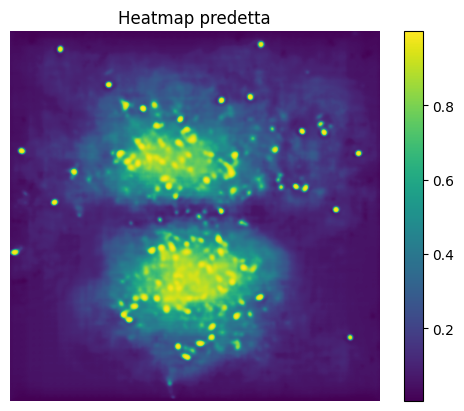

(800, 800)
Min: 0.004875489
Max: 0.9981781
Mean: 0.22449672
[[0.02350604 0.02455455 0.02030621 ... 0.01659492 0.01912995 0.01848644]
 [0.0355568  0.03753379 0.03027225 ... 0.02107567 0.02588173 0.02276877]
 [0.03244234 0.03644195 0.03204115 ... 0.02196357 0.02481904 0.02204017]
 ...
 [0.02910669 0.02842601 0.02393577 ... 0.01713215 0.02155424 0.01972998]
 [0.02913733 0.02982186 0.02406201 ... 0.0177302  0.02365633 0.0216161 ]
 [0.02178887 0.02073923 0.01805159 ... 0.01447596 0.01838785 0.01713033]]


In [4]:
img_path = '/user/gr1/delphi/dghezzi/UNet/Models/event_92.npy'

img = np.load(img_path)  # shape atteso (H, W)
img = img.astype(np.float32)  # assicurati che sia in float32
img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(img_tensor)  # shape attesa (1, 1, H, W)
    outputs = torch.sigmoid(outputs)  # applica sigmoid per ottenere valori tra 0 e 1

outputs = outputs.squeeze(0).squeeze(0).cpu().numpy()  # rimuovi dimensioni non necessarie

plt.imshow(outputs)
plt.title("Heatmap predetta")
plt.colorbar()
plt.axis('off')
plt.show()
plt.imsave("heatmap_predetta.png", outputs)

print(outputs.shape)
print("Min:", outputs.min())
print("Max:", outputs.max())
print("Mean:", outputs.mean())
print(outputs)

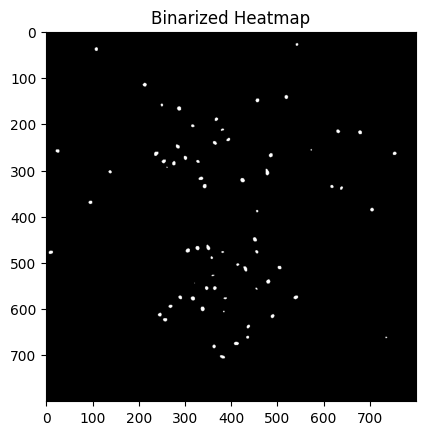

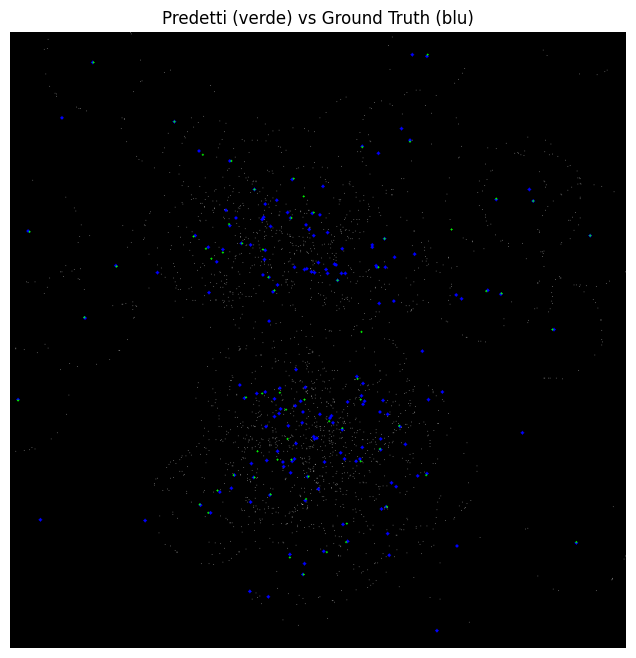

Threshold in pixels: 4 ==> precision: 0.7353, recall: 0.2907, f1-score: 0.4167


In [5]:
from UNet import infer_keypoints_from_image, img_kp_pred_and_gr, compute_pck_metrics, load_keypoints_from_csv

heatmap, keypoints_and_cov, time = infer_keypoints_from_image(img_path, model, device=device, show_mask=True, threshold=0.97, npy=True, sigmoid=True)

keypoints = [kp for kp, cov in keypoints_and_cov]
keypoints_gt = load_keypoints_from_csv('/user/gr1/delphi/dghezzi/UNet/Models/event_92_centers.csv')
img_kp_pred_and_gr(keypoints_pred=keypoints, keypoints_gt=keypoints_gt, img_path=img_path)
pck_metrics = compute_pck_metrics(keypoints_gt, keypoints, thresholds=[4])
print(f'Threshold in pixels: 4 ==> precision: {pck_metrics[0][0]:.4f}, recall: {pck_metrics[1][0]:.4f}, f1-score: {pck_metrics[2][0]:.4f}')

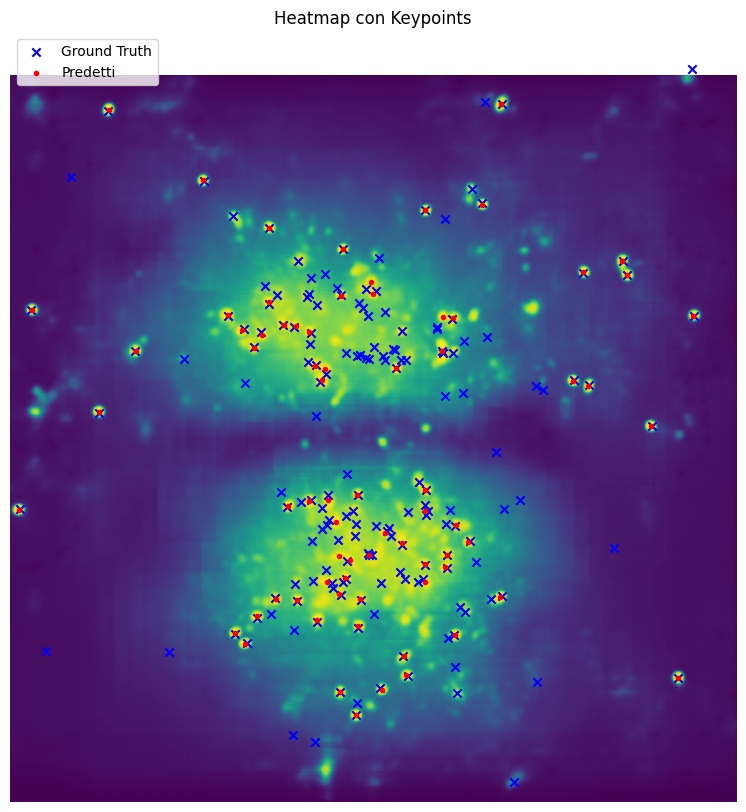

In [14]:
# sovrapponi heatmap e keypoints predetti
plt.figure(figsize=(10, 10))
plt.imshow(outputs, cmap='viridis')
plt.scatter(*zip(*keypoints_gt), c='blue', marker='x', label='Ground Truth')
plt.scatter(*zip(*keypoints), c='red', marker='.', label='Predetti')
plt.title("Heatmap con Keypoints")
plt.axis('off')
plt.legend()
plt.show()